In [2]:
import requests
import json
import sys
import numpy as np
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn as sk
import torch
import test_utils_models
from importlib import reload
from torch.utils.data import DataLoader, TensorDataset
import Transformer
import TransformerV2
import TransformerService
import torch.optim as optim
import torch.nn as nn
import test_utils
import DataVisualizations
import Utilities

In [3]:
url = 'http://localhost:8000/sequenceset_manager/get_sequence_data'

# features = ['pctChgclose', 'pctChgvolume', 'opHi', 'opCl','hiCl','loCl','opLo',"pctDiff+ema5_close", "pctDiff+ema10_close", "pctDiff+ema20_close",'pctDiff+ema50_close', 'pctDiff+ema100_close',
# 'pctDiff+ema200_close','pctDiff+bb_high_close10', 'pctDiff+bb_low_close10', 'pctDiff+smaVol10_volume', 'pctDiff+smaVol20_volume', 'pctChgClOp', 'macd_signal','bb_indicator20',"bb_indicator50",
#             ]
# struct_features = ['open', 'high', 'low', 'close', 'ema20', 'ema50', 'ema100']
# struct_features = ['close']
struct_features = []
# features = ['pctChgclose','pctChgvolume','opHi', 'opCl','hiCl','loCl','opLo']
# features = ['pctChgclose']
features = ['open', 'high', 'low', 'close', 'ema20', 'ema50', 'ema100']
# target_features = ['pctChgclose+{}'.format(i) for i in range(1, 3) ]
target_features = ['close+{}'.format(i) for i in range(1, 15) ]
# target_features = ['cumPctChg+{}'.format(i) for i in range(1,11) ]

indices_seq = list(range(len(features + struct_features + target_features)))

feature_dict = {col: index for col, index in zip(features+struct_features + target_features, indices_seq)}


In [4]:
print(feature_dict)

{'open': 0, 'high': 1, 'low': 2, 'close': 3, 'ema20': 4, 'ema50': 5, 'ema100': 6, 'close+1': 7, 'close+2': 8, 'close+3': 9, 'close+4': 10, 'close+5': 11, 'close+6': 12, 'close+7': 13, 'close+8': 14, 'close+9': 15, 'close+10': 16, 'close+11': 17, 'close+12': 18, 'close+13': 19, 'close+14': 20}


In [6]:
# tickers = ['MSFT', 'AAPL', 'AMZN','QQQ','SPY','F', 'TSLA', "BAC", "LLY", "PEP" ]
# tickers = ['AAPL', 'MSFT']
tickers = ["AAPL", "SPY", "QQQ", "XOM", "MSFT", "AMZN", "BB", 'F', 'TSLA', 'GE',
           "JPM", "BAC", "LLY", "NKE", "WMT", "PEP"]
sequence_lengths = [20]
all_sequences = []

all_params = []

for ticker in tickers:
    for sequence_length in sequence_lengths:
        all_params.append({
            'ticker': ticker,
            'features': features + struct_features + target_features,
            'interval': '1d',
            'start_date': '2007-01-01',
            'sequence_length': sequence_length
        })
for params in all_params:

    response = requests.get(url, params=params)
    if response.status_code == 200:
        try:
            data = response.json()
            all_sequences.append(data)
        except json.JSONDecodeError as e:
            print(f"Failed to decode JSON: {e}")
            print("Response text:", response.text)
    else:
        print(f"Request failed with status code {response.status_code}")

In [7]:
print(len(all_sequences))

16


In [8]:
print(all_sequences[-1][-500]['end_timestamp'])
print(all_sequences[-1][-500]['start_timestamp'])


2022-09-19T00:00:00Z
2022-08-22T00:00:00Z


In [9]:
target_feauture_index = [feature_dict[col] for col in target_features]
for index in target_feauture_index:
    print(all_sequences[-1][-500]['sliced_data'][-1][index])

168.9199981689453
168.44000244140625
168.60000610351562
168.52000427246094
168.4499969482422
166.00999450683594
168.6699981689453
166.61000061035156
163.25999450683594
165.25
167.11000061035156
166.0
162.8000030517578
161.61000061035156


In [10]:
def create_3d_array(stock_sequences, max_len_seq):
    # Create a 3D array to store the sequences
    # The array will have the shape (num_sequences, sequence_length, num_features)
    # stock sequences is a list of sequence_dicts where each sequence_dict is a dictionary
    # we are extracting 'sliced_data' from each sequence_dict and creating 3d np array

    num_features = len(features) + len(struct_features)

    sequence_steps = len(stock_sequences[0]['sliced_data'])

    num_sequences = len(stock_sequences)
    X = np.zeros((num_sequences, sequence_steps, num_features))
    y = np.zeros((num_sequences, len(target_features)))

    indices_map = {}
    cur_index = 0
    for i, sequence_dict in enumerate(stock_sequences):
        X_cols = [feature_dict[col] for col in features + struct_features]
        y_cols = [feature_dict[col] for col in target_features]

        X[i, :, :] = np.array(sequence_dict['sliced_data'])[:, X_cols]
        X_padded = np.zeros((num_sequences, max_len_seq, num_features))
        X_padded[:, :sequence_steps, :] = X
        y[i, :] = np.array(sequence_dict['sliced_data'])[-1, y_cols]




    return X_padded, y

In [11]:
def preprocess_multi_stock(all_sequences, max_seq_length, test_size=0.1):
    X_train = np.zeros((0, 0, 0))
    X_test = np.zeros((0, 0, 0))
    y_train = np.zeros((0, 0))
    y_test = np.zeros((0, 0))
    
    test_seq_objs = []
    train_seq_objs = []
    for sequences in all_sequences:
        print(len(sequences))
        X, y = create_3d_array(sequences,max_seq_length)
        print(X.shape)

        for i in range(len(X)-1, 0, -1):
            if np.isnan(y[i]).any():
                X = np.delete(X, i, axis=0)
                y = np.delete(y, i, axis=0)

        X_train_cur, X_test_cur, y_train_cur, y_test_cur = train_test_split(X, y, test_size=test_size, shuffle=False)
        
        train_seq_objs += [sequences[i] for i in range(len(X_train_cur))]
        test_seq_objs += [sequences[i] for i in range(len(X_train_cur), len(X_train_cur)+len(X_test_cur))]

        # scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
        # X_train_cur = scaler.fit_transform(X_train_cur)
        # X_test_cur = scaler.transform(X_test_cur)
        # 
        y_scaler = sk.preprocessing.StandardScaler()
        # y_train_cur = y_scaler.fit_transform(y_train_cur)
        # y_test_cur = y_scaler.transform(y_test_cur)
        
        # X_train_cur = X_train_cur[0:-25, :, :]
        # y_train_cur = y_train_cur[0:-25, :]
        # X_test_cur = X_test_cur[0:-25, :, :]
        # y_test_cur = y_test_cur[0:-25, :]


        if X_train.shape[0] == 0:
            X_train = X_train_cur
            X_test = X_test_cur
            y_train = y_train_cur
            y_test = y_test_cur
        else:
            X_train = np.concatenate((X_train, X_train_cur), axis=0)
            X_test = np.concatenate((X_test, X_test_cur), axis=0)
            y_train = np.concatenate((y_train, y_train_cur), axis=0)
            y_test = np.concatenate((y_test, y_test_cur), axis=0)

    return X_train, X_test, y_train, y_test, y_scaler, train_seq_objs, test_seq_objs


In [12]:
X_train_whole, X_test, y_train_whole, y_test, y_scaler,train_seq_objs, test_seq_objs = preprocess_multi_stock(all_sequences, max(sequence_lengths))

4436
(4436, 20, 7)
4436
(4436, 20, 7)
4436
(4436, 20, 7)
4436
(4436, 20, 7)
4436
(4436, 20, 7)
4436
(4436, 20, 7)
4436
(4436, 20, 7)
4436
(4436, 20, 7)
3558
(3558, 20, 7)
4436
(4436, 20, 7)
4436
(4436, 20, 7)
4436
(4436, 20, 7)
4436
(4436, 20, 7)
4436
(4436, 20, 7)
4436
(4436, 20, 7)
4436
(4436, 20, 7)


In [13]:
def sample_training_data(X_train, y_train, percentage=0.3):
    # Get the number of samples
    num_samples = X_train.shape[0]

    # Calculate the number of samples for 30%
    num_samples_to_sample = int(percentage * num_samples)

    # Randomly sample indices (without replacement)
    sampled_indices = np.random.choice(num_samples, num_samples_to_sample, replace=False)

    # Extract the same indices from both X_train and y_train
    X_sampled = X_train[sampled_indices]
    y_sampled = y_train[sampled_indices]

    return X_sampled, y_sampled

In [14]:
## sample random 30% of the sequences for training set and get rid of the rest
X_train, y_train = sample_training_data(X_train_whole, y_train_whole, percentage=1)

In [15]:


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(62874, 20, 7) (7000, 20, 7) (62874, 14) (7000, 14)


In [16]:
print(feature_dict)

{'open': 0, 'high': 1, 'low': 2, 'close': 3, 'ema20': 4, 'ema50': 5, 'ema100': 6, 'close+1': 7, 'close+2': 8, 'close+3': 9, 'close+4': 10, 'close+5': 11, 'close+6': 12, 'close+7': 13, 'close+8': 14, 'close+9': 15, 'close+10': 16, 'close+11': 17, 'close+12': 18, 'close+13': 19, 'close+14': 20}


In [17]:
if len(struct_features) > 0:
    X_train_scaled = Utilities.scale_sequence_by_group(struct_features, feature_dict, X_train)
    X_test_scaled = Utilities.scale_sequence_by_group(struct_features, feature_dict, X_test)
else:
    X_train_scaled = X_train
    X_test_scaled = X_test

In [18]:
x_indices = [feature_dict[col] for col in features]

# scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
# X_train_scaled[:,:,x_indices] = scaler.fit_transform(X_train[:,:,x_indices])
# X_test_scaled[:,:,x_indices] = scaler.transform(X_test[:,:,x_indices])
# 
# y_train_scaled = y_scaler.fit_transform(y_train)
# y_test_scaled = y_scaler.transform(y_test)
X_train_scaled = X_train
X_test_scaled = X_test
y_train_scaled = y_train
y_test_scaled = y_test

In [19]:
y_train_scaled = np.expand_dims(y_train_scaled, axis=2)
y_test_scaled = np.expand_dims(y_test_scaled, axis=2)
print(y_train_scaled.shape, y_test_scaled.shape)

(62874, 14, 1) (7000, 14, 1)


In [20]:
print(X_train_scaled.shape, X_test_scaled.shape)

(62874, 20, 7) (7000, 20, 7)


In [21]:
print(X_train_scaled[0,:,-1])

[49.66273218 49.7126781  49.74658545 49.79709862 49.86685904 49.93513903
 50.00657191 50.08911503 50.20413253 50.31439722 50.40099331 50.49156767
 50.58430889 50.68546121 50.77565013 50.84806298 50.92394293 50.99317174
 51.07761388 51.15474033]


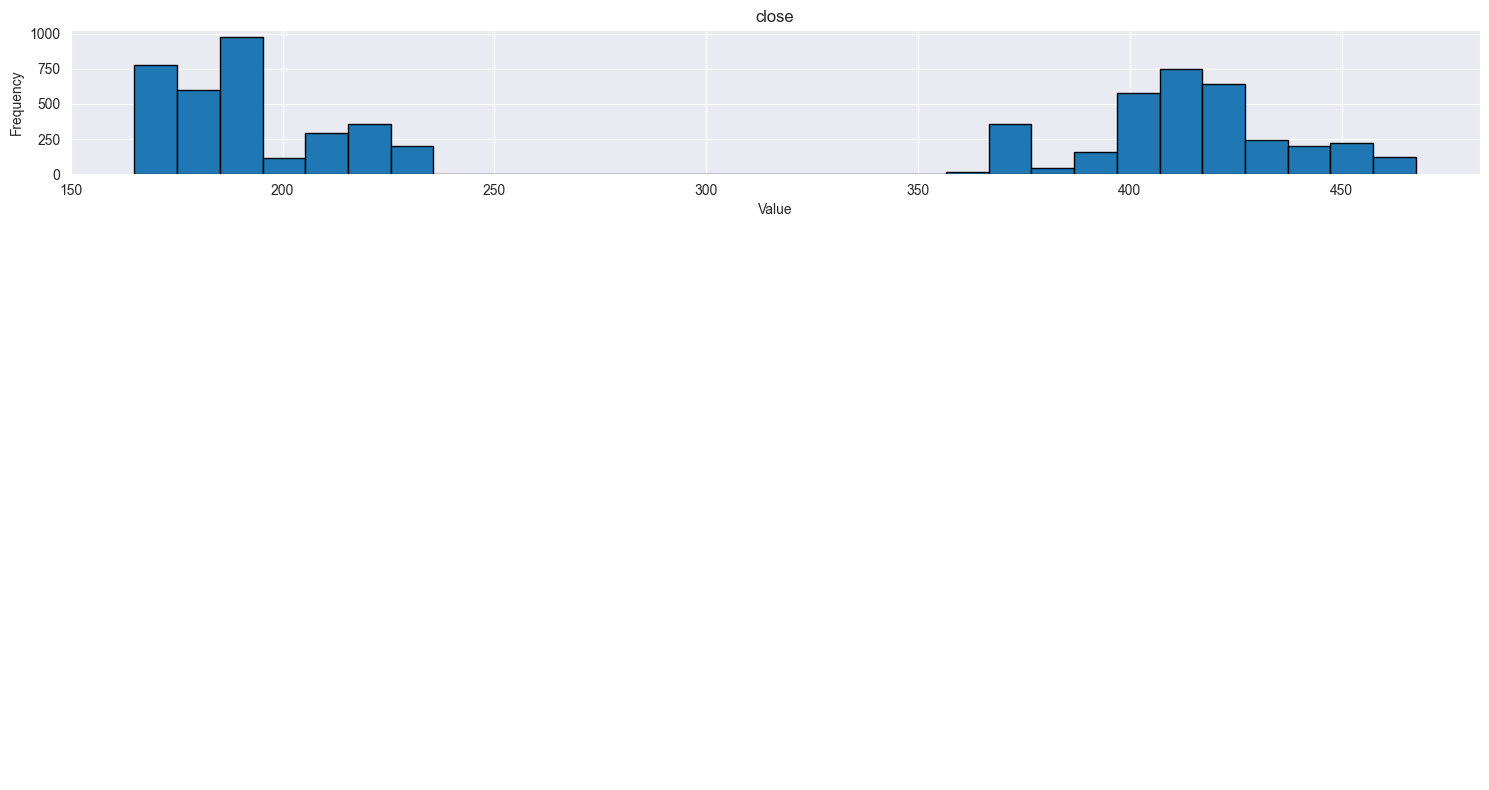

In [172]:
# DataVisualizations.plot_feature_histograms(X_test_scaled, features + struct_features, feature_dict)


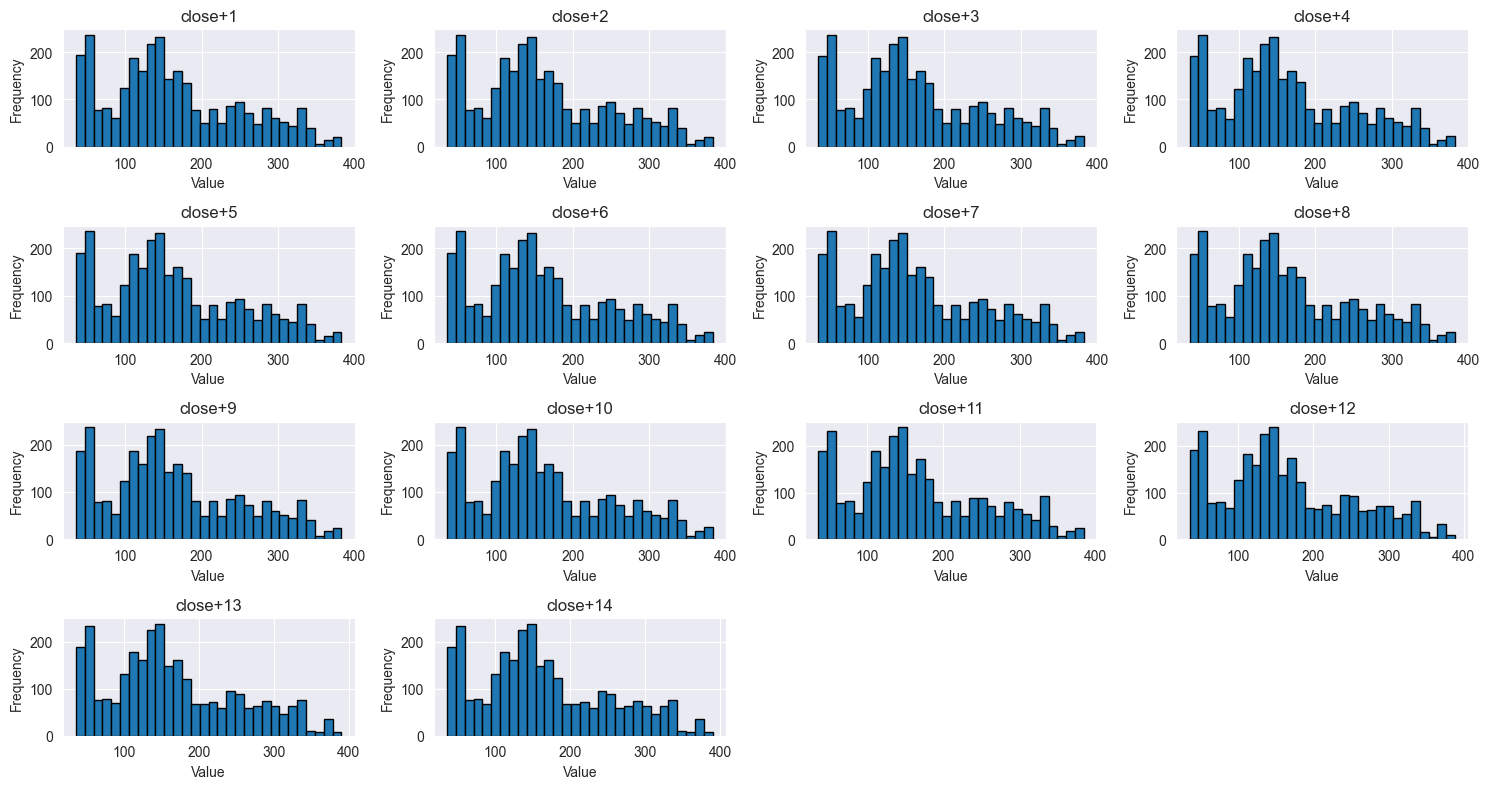

In [173]:
# DataVisualizations.plot_y_feature_histograms(y_train_scaled, target_features)

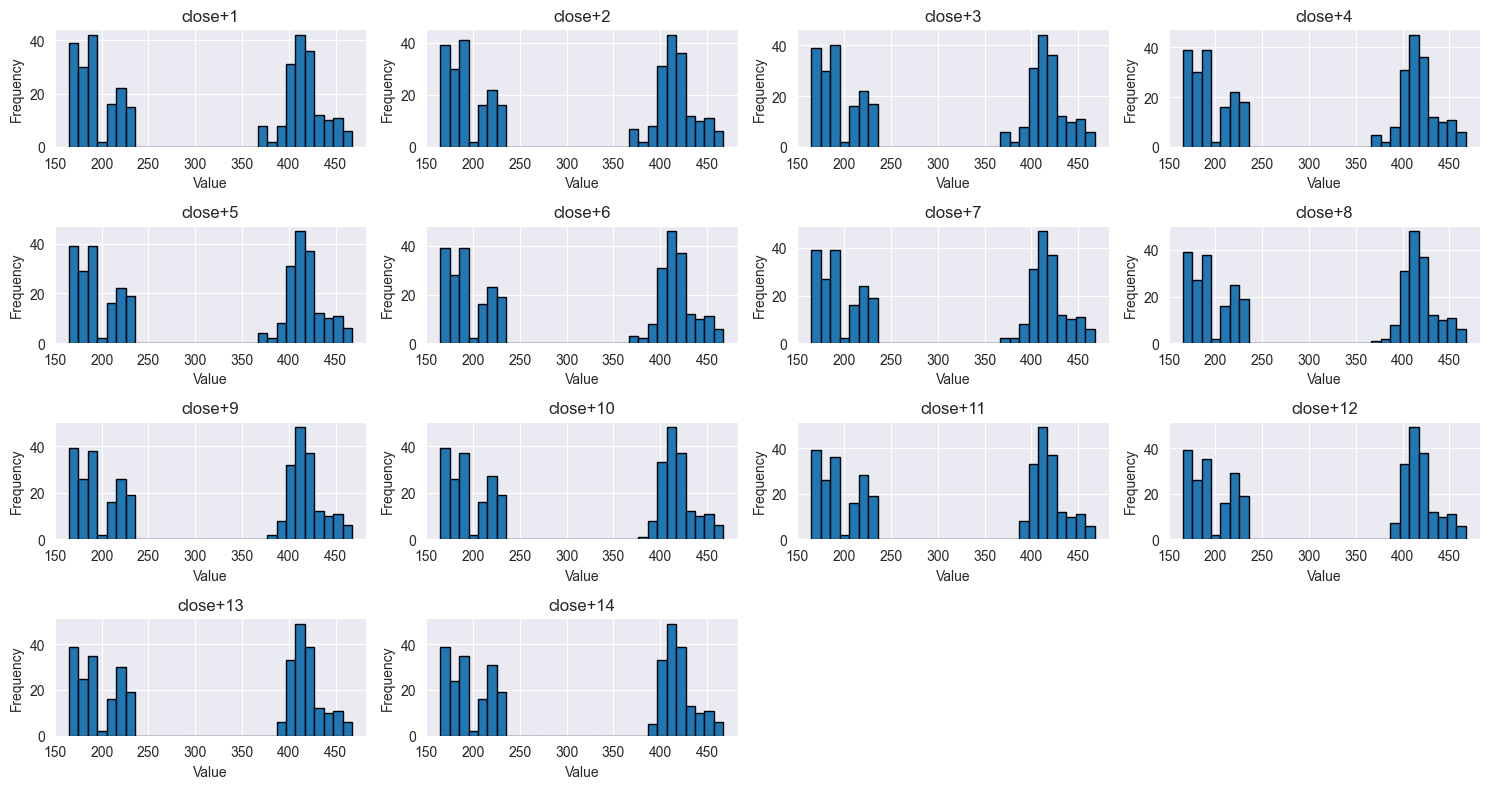

In [174]:
# DataVisualizations.plot_y_feature_histograms(y_test_scaled, target_features)

In [175]:
# DataVisualizations.plot_y_feature_histograms(np.expand_dims(y_scaler.inverse_transform(y_train_scaled.squeeze()),-1), target_features)


NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [22]:
# DataVisualizations.plot_y_feature_histograms(np.expand_dims(y_train,-1), target_features)


In [23]:
reload(DataVisualizations)

<module 'DataVisualizations' from '/Users/andrewpassero/Documents/TradeLensForcast/DataVisualizations.py'>

In [153]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    print("MPS is available. Setting as default device.")
    device = torch.device("mps")
    torch.set_default_device(device)

print(f"Using device: {device}")
batch_size = 64

# Convert data to tensors and move them to the appropriate device
print(X_train_scaled.shape)
print(y_train_scaled.shape)
# X_train_scaled_concat = np.concatenate((X_train_scaled, y_train_scaled), axis=-1)
# print(X_train_scaled_concat.shape)
# X_test_scaled_concat = np.concatenate((X_test_scaled, y_test_scaled), axis=-1)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).to(device)

print(X_train_tensor.device, X_test_tensor.device, y_train_tensor.device, y_test_tensor.device)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

generator = torch.Generator(device=device)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

MPS is available. Setting as default device.
Using device: mps
(62874, 20, 7)
(62874, 14, 1)
mps:0 mps:0 mps:0 mps:0


In [154]:
print(X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape)

torch.Size([62874, 20, 7]) torch.Size([62874, 14, 1]) torch.Size([7000, 20, 7]) torch.Size([7000, 14, 1])


In [217]:
num_layers = 4
d_model = 256
num_heads = 2
d_ff = 512
input_dim = X_train_tensor.shape[2]  # Number of features in X_train
output_dim = 1  # Since y_train has shape (batch, output_steps, 1)

# Initialize the Transformer models
model = TransformerV2.Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    d_ff=d_ff,
    encoder_input_dim=input_dim,
    decoder_input_dim=output_dim,
    dropout=.2
).to(device)
print(next(model.parameters()).device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

print(f'The model has {count_parameters(model):,} trainable parameters')

Initializing TransformerEncoder with 4 layers
PositionalEncoding initialized with shape: torch.Size([1, 200, 256])
TransformerEncoder initialized with 4 layers
PositionalEncoding initialized with shape: torch.Size([1, 200, 256])
Transformer initialized with 2 layers
mps:0
The model has 5,347,586 trainable parameters


In [222]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# base_optimizer = optim.Adam
# optimizer = torch.optim.SGD(models.parameters(), lr=1e-3, momentum=0.9)

# optimizer = Transformer.SAM(models.parameters(), base_optimizer, rho=0.3, lr=0.01)
# criterion = nn.MSELoss()
# get mae criterian 
# criterion = nn.L1Loss()
# criterion = nn.HuberLoss(delta=1.0)
criterion = Transformer.gaussian_nll_loss
# Initialize the Trainer with the device
trainer = TransformerService.Trainer(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    max_length=14,
    start_token_value=-999 # Start token value, adjust if necessary
)

In [223]:
from importlib import reload
reload(Transformer)
reload(TransformerService)
reload(TransformerV2)

<module 'TransformerV2' from '/Users/andrewpassero/Documents/TradeLensForcast/TransformerV2.py'>

In [224]:
epochs = 2000

# Train the models

trainer.fit(train_dataloader, test_dataloader, epochs=epochs, clip_value=1)

Epoch 1 | Train Loss: 1.513 | Val Loss: 20625.384
Epoch 2 | Train Loss: 1.499 | Val Loss: 27345.359
Epoch 3 | Train Loss: 1.495 | Val Loss: 26992.377
Epoch 4 | Train Loss: 1.488 | Val Loss: 23306.923
Epoch 5 | Train Loss: 1.482 | Val Loss: 28467.762
Epoch 6 | Train Loss: 1.476 | Val Loss: 18135.791
Epoch 7 | Train Loss: 1.473 | Val Loss: 27366.327
Epoch 8 | Train Loss: 1.468 | Val Loss: 23162.859
Epoch 9 | Train Loss: 1.462 | Val Loss: 26479.208
Epoch 10 | Train Loss: 1.460 | Val Loss: 16560.743
Epoch 11 | Train Loss: 1.456 | Val Loss: 21386.893
Epoch 12 | Train Loss: 1.449 | Val Loss: 22481.868
Epoch 13 | Train Loss: 1.441 | Val Loss: 22435.127
Epoch 14 | Train Loss: 1.437 | Val Loss: 18927.890
Epoch 15 | Train Loss: 1.431 | Val Loss: 18724.700
Epoch 16 | Train Loss: 1.428 | Val Loss: 19798.197
Epoch 17 | Train Loss: 1.424 | Val Loss: 23940.686
Epoch 18 | Train Loss: 1.423 | Val Loss: 19477.429
Epoch 19 | Train Loss: 1.418 | Val Loss: 18573.668
Epoch 20 | Train Loss: 1.415 | Val Loss:

KeyboardInterrupt: 

In [220]:
file_path = "saved_models/model_weights20240928_171203.pth"
model.load_state_dict(torch.load(file_path, map_location=device))

/var/folders/d8/cz684bdx7pbc12fnsyp2z9mm0000gn/T/ipykernel_42368/3875937369.py:2: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



<All keys matched successfully>

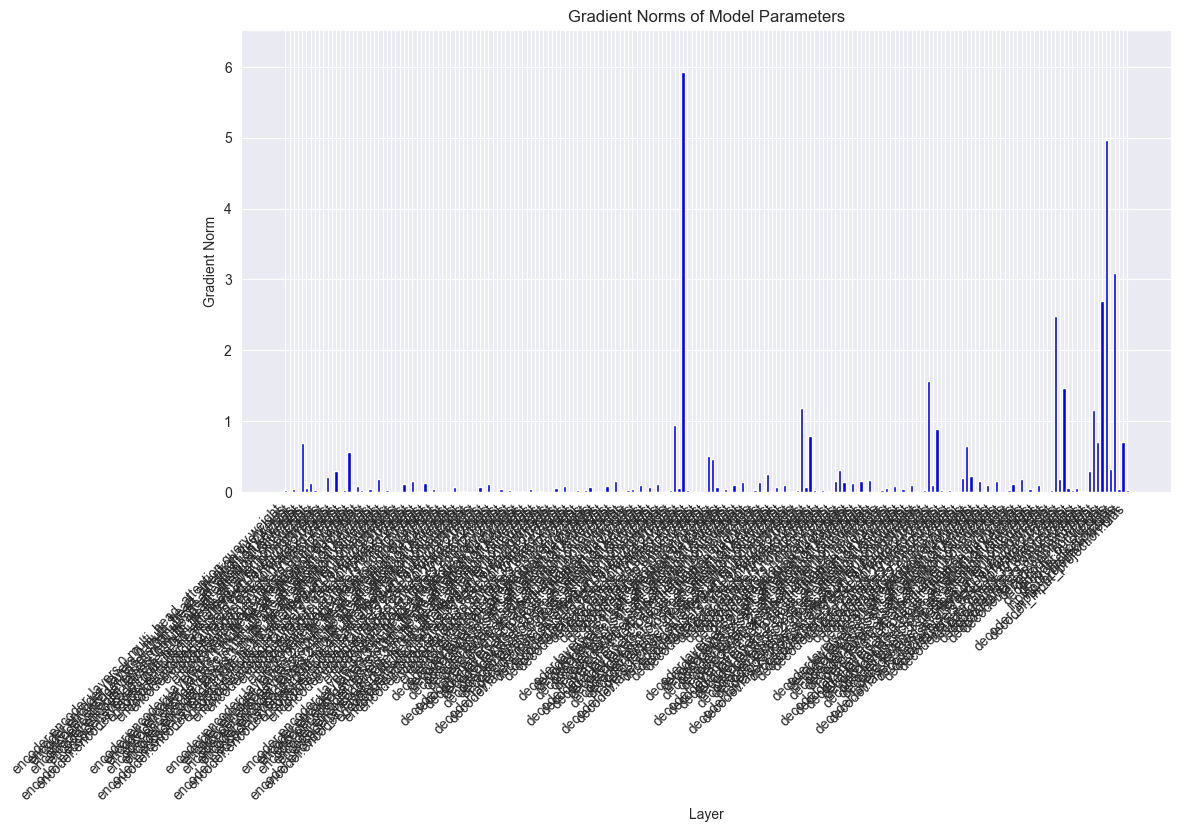

In [225]:
gradient_test_X = X_train_tensor[-64:]
gradient_test_y = y_train_tensor[-64:]

gradients = trainer.log_gradients_with_names(gradient_test_X, gradient_test_y)
DataVisualizations.visualize_gradients(gradients)

In [201]:
# y_pred = trainer.predict(X_test_tensor)
y_pred = trainer.predict(X_train_tensor[:64])
# y_pred = trainer.sequence_predictions
print(y_pred.shape)

Predictions shape: torch.Size([64, 14, 2])
Last attention shape: torch.Size([64, 14, 256])
torch.Size([64, 14, 2])


In [202]:
mu_pred = y_pred[:, :, 0]
log_var_pred = y_pred[:, :, 1]
variance_pred = torch.exp(log_var_pred)
std_pred = torch.sqrt(variance_pred)
print(mu_pred.shape, std_pred.shape)


torch.Size([64, 14]) torch.Size([64, 14])


In [203]:
# mu_pred_denorm = y_scaler.inverse_transform(mu_pred.detach().cpu().numpy())
# std_pred_denorm = y_scaler.inverse_transform(std_pred.detach().cpu().numpy())
mu_pred_denorm = mu_pred.detach().cpu().numpy()
std_pred_denorm = std_pred.detach().cpu().numpy()

In [204]:
trainer.generate_model_architecture()

Model Architecture:
------------------
'transformer_encoder'
'transformer_decoder'
'transformer_encoder:encoder_layer0'
'transformer_encoder:encoder_layer1'
'transformer_encoder:encoder_layer2'
'transformer_encoder:encoder_layer3'
'transformer_decoder:decoder_layer0'
'transformer_decoder:decoder_layer1'
'transformer_decoder:decoder_layer2'
'transformer_decoder:decoder_layer3'
'transformer_encoder:encoder_layer0:multi_head_attention'
'transformer_encoder:encoder_layer1:multi_head_attention'
'transformer_encoder:encoder_layer2:multi_head_attention'
'transformer_encoder:encoder_layer3:multi_head_attention'
'transformer_decoder:decoder_layer0:self_attention'
'transformer_decoder:decoder_layer0:cross_attention'
'transformer_decoder:decoder_layer1:self_attention'
'transformer_decoder:decoder_layer1:cross_attention'
'transformer_decoder:decoder_layer2:self_attention'
'transformer_decoder:decoder_layer2:cross_attention'
'transformer_decoder:decoder_layer3:self_attention'
'transformer_decoder:d

In [205]:
# retrieval_list = ["transformer_encoder:encoder_layer0:multi_head_attention",
# "transformer_encoder:encoder_layer1:multi_head_attention",
# "transformer_decoder:decoder_layer0:self_attention",
# "transformer_decoder:decoder_layer0:cross_attention",
# "transformer_decoder:decoder_layer1:self_attention",
# "transformer_decoder:decoder_layer1:cross_attention"]
retrieval_list = ['transformer_encoder:encoder_layer0:multi_head_attention',"transformer_decoder:decoder_layer0:cross_attention"]
retrieval_dict = trainer.retreive_attention_scores(retrieval_list)

In [206]:
print(retrieval_dict['transformer_encoder:encoder_layer0:multi_head_attention'].shape)
print(len(retrieval_dict))

torch.Size([64, 20, 256])
2


In [207]:
retrieval_list = ['transformer_encoder:encoder_layer0', 'transformer_decoder:decoder_layer0']
output_dict = trainer.retrieve_output(retrieval_list)

In [208]:
print(y_pred.shape)

torch.Size([64, 14, 2])


In [209]:
reload(test_utils)
reload(Transformer)
reload(TransformerV2)
reload(TransformerService)
reload(DataVisualizations)

<module 'DataVisualizations' from '/Users/andrewpassero/Documents/TradeLensForcast/DataVisualizations.py'>

In [210]:
mu_pred = mu_pred_denorm.squeeze()
std_pred = std_pred_denorm.squeeze()

In [211]:
print(mu_pred.shape)

(64, 14)


In [212]:
output_string, results, predicted_y_old = test_utils.eval_model(y_train[:64], mu_pred, num_days = y_pred.shape[1], alreadyCum=True)

(64, 14)
14


In [213]:
print(output_string)

Cluster Number:
Accuracy1D 82.81% PredictedRet: 7.982627868652344 ActRet: 69.25754443183541
Accuracy2D 70.31% PredictedRet: 9.119107246398926 ActRet: 69.30283250287175
Accuracy3D 60.94% PredictedRet: 18.33936309814453 ActRet: 69.10035492479801
Accuracy4D 89.06% PredictedRet: 9.71933364868164 ActRet: 69.22410601750016
Accuracy5D 53.12% PredictedRet: 22.349504470825195 ActRet: 69.11328615993261
Accuracy6D 87.5% PredictedRet: 10.287004470825195 ActRet: 69.00034592673182
Accuracy7D 51.56% PredictedRet: 15.834296226501465 ActRet: 69.16432940587401
Accuracy8D 73.44% PredictedRet: 9.261615753173828 ActRet: 69.26602309942245
Accuracy9D 50.0% PredictedRet: 17.178749084472656 ActRet: 69.70264331996441
Accuracy10D 79.69% PredictedRet: 9.344205856323242 ActRet: 69.7212438210845
Accuracy11D 50.0% PredictedRet: 18.72991180419922 ActRet: 69.68320538848639
Accuracy12D 79.69% PredictedRet: 9.196405410766602 ActRet: 69.64599112793803
Accuracy13D 50.0% PredictedRet: 17.907794952392578 ActRet: 69.45199842

In [214]:
test_utils.visualize_future_distribution(results)

(64, 29)


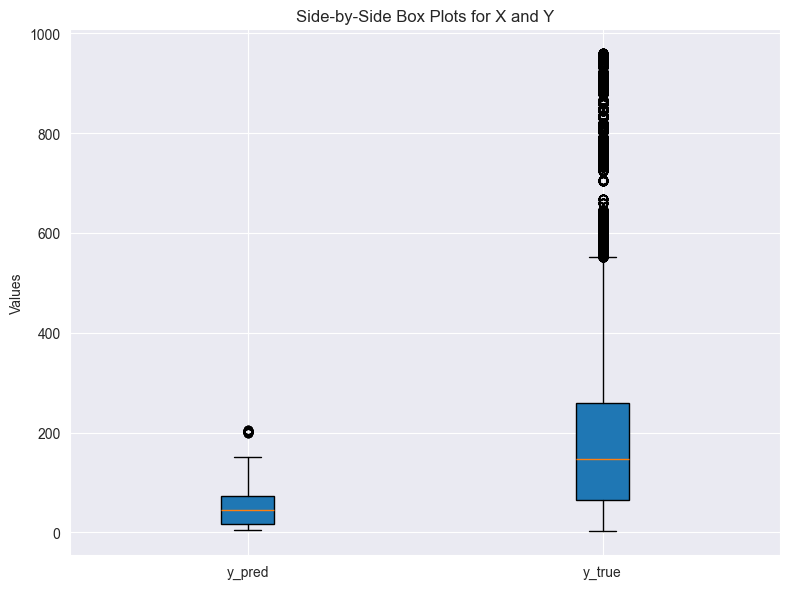

In [195]:
DataVisualizations.visualize_step_distribution(mu_pred,y_test)

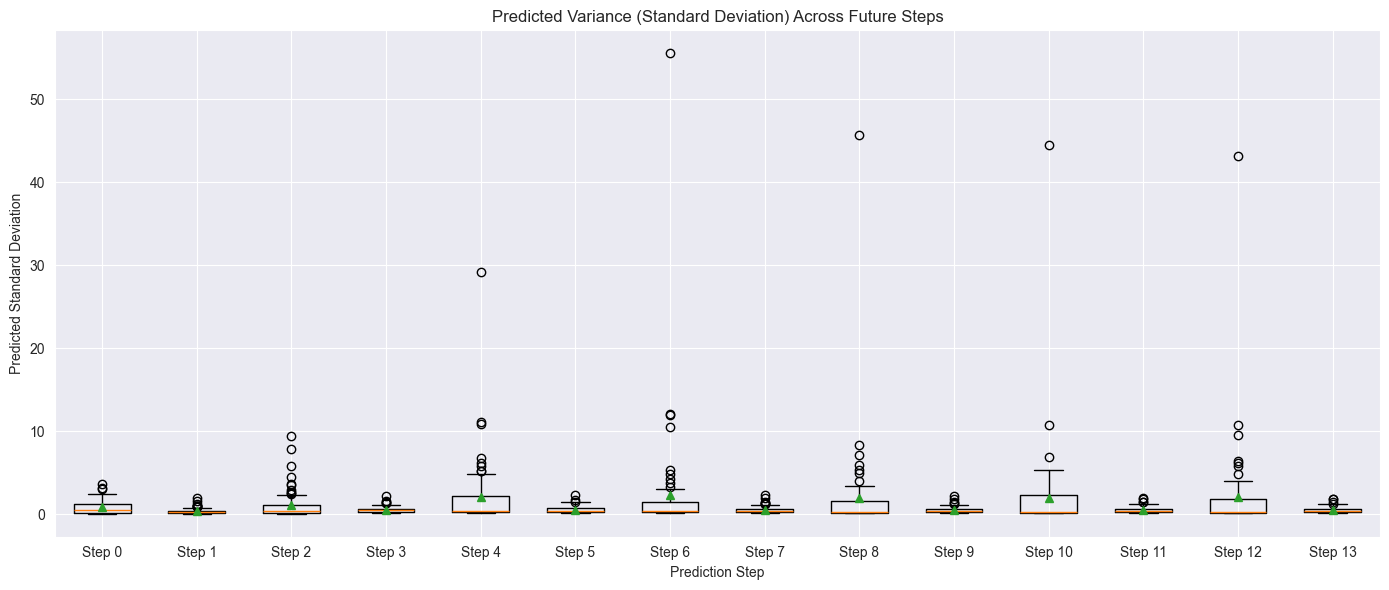

In [173]:
# visualize variance
DataVisualizations.visualize_std(std_pred)

In [129]:
DataVisualizations.plot_residuals(y_test ,mu_pred, std_pred)

ValueError: operands could not be broadcast together with shapes (7000,14) (64,14) 

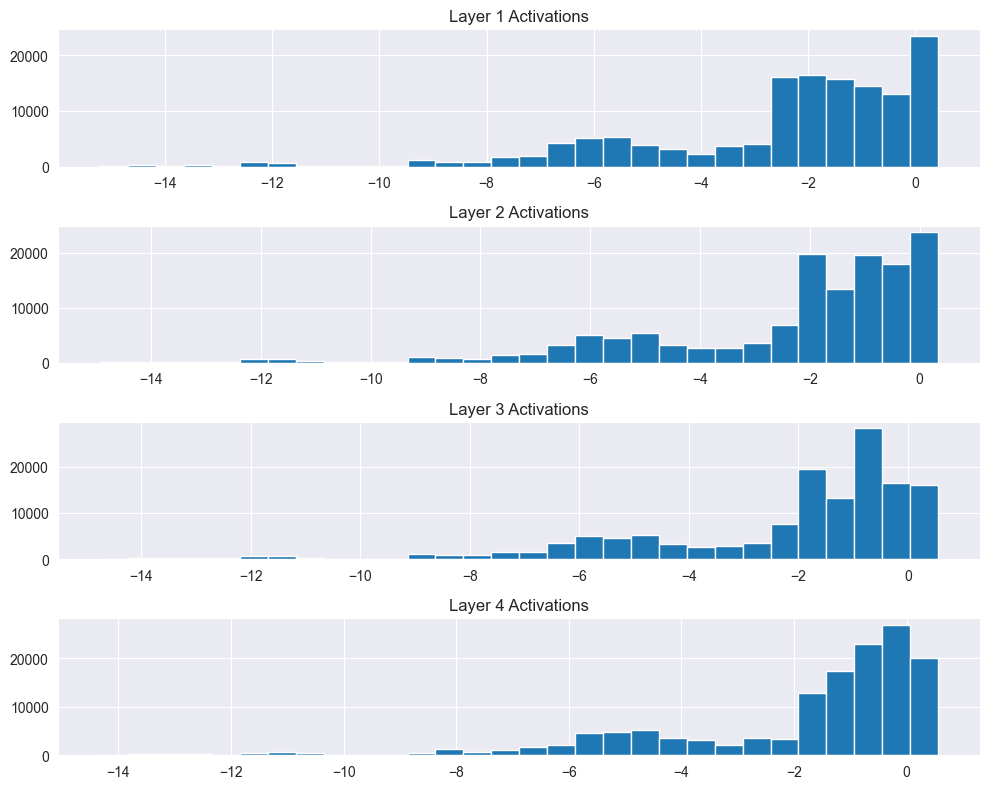

In [130]:
DataVisualizations.plot_layer_activations(model, X_test_tensor)

2022-10-21T00:00:00Z
2022-11-17T00:00:00Z
[54.70500183 55.99250031 56.14749908 54.74000168 55.20500183 56.75249863
 56.76499939 56.09999847 56.75749969 57.52249908 59.05250168 58.96749878
 58.83000183 58.59249878]
[12.067101  11.474728  11.345525  11.684888  11.739305  11.606429
 12.313982  11.674384  11.838209  11.961859  12.303309  12.182987
 12.0135145 12.108625 ]


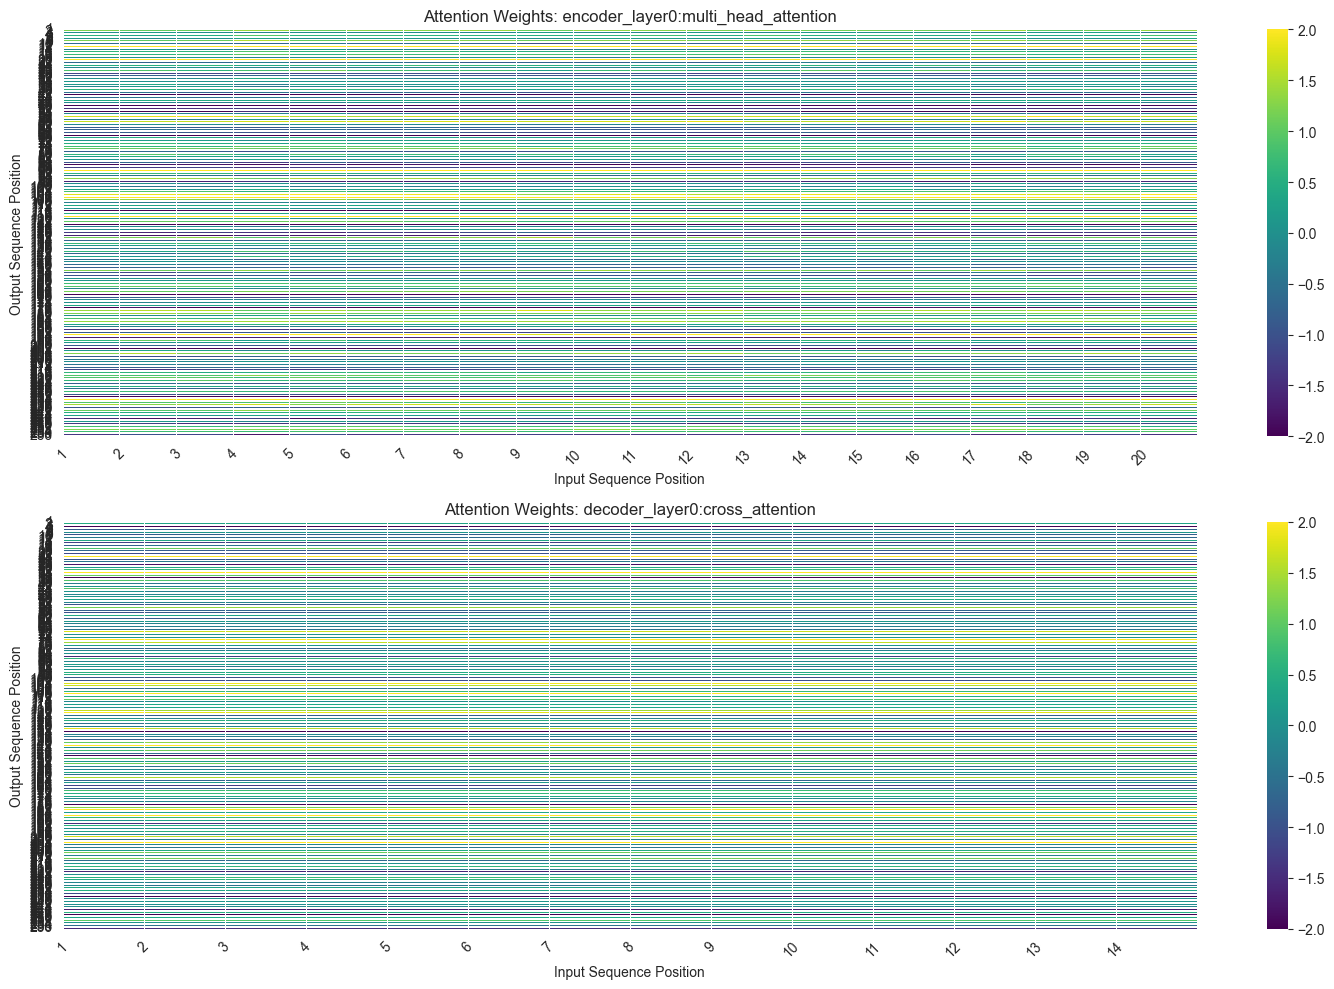

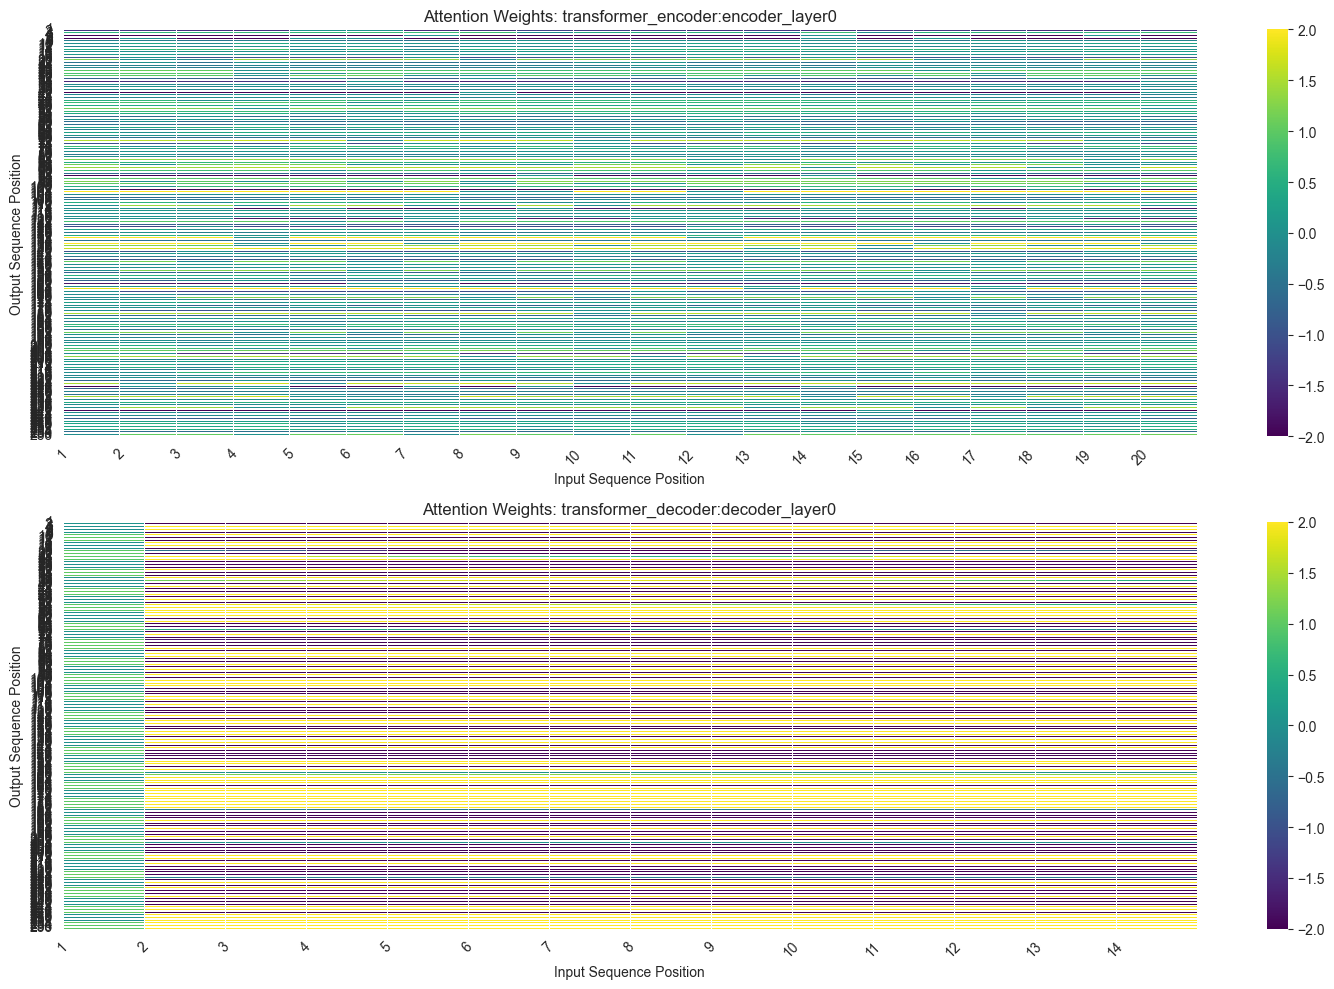

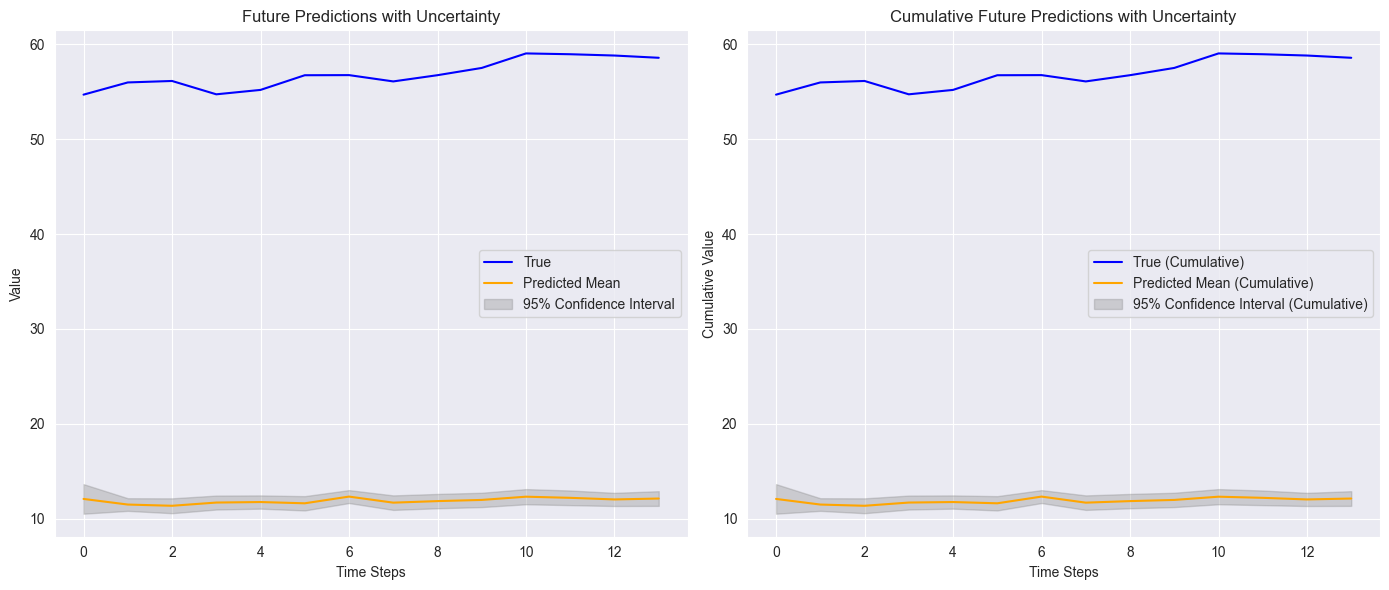

In [196]:
for i in range(0, 1):

    # print(test_seq_objs[i]['ticker'])
    print(test_seq_objs[i]['start_timestamp'])
    print(test_seq_objs[i]['end_timestamp'])
    print(y_train[i])
    print(mu_pred[i])
    DataVisualizations.layer_heatmap(retrieval_dict, i)
    DataVisualizations.layer_heatmap(output_dict, i)
    DataVisualizations.visualize_future_predictions_with_uncertainty(y_train[i], mu_pred[i], std_pred[i], already_cumulative=True)

In [ ]:
# embeddings = DataVisualizations.extract_embeddings(models, X_test_tensor[:1000])
# DataVisualizations.visualize_embeddings(embeddings, method='tsne', perplexity=50)

In [226]:
from datetime import datetime

# add date/time to models name
model_name = 'model_weights' + datetime.now().strftime("%Y%m%d_%H%M%S")
print(model_name)
torch.save(model.state_dict(), 'saved_models/' + model_name + '.pth')

model_weights20240928_193004
